In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# correlate the strength of the island detection with AEP components at THAT bin (first, second event)

# for long stays in the island: show cells don't drop their FR in miss but drop in success


# PSTH across tgt selective units (onset- or just stay- selective)
# specifically 5-7 seconds before entering: FR should slowly decay
# reflecting the chances of attentive state before entering the island

### Session data

In [5]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [32]:
session = selected_009266[8]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-04-24_10-08-11'

### Choose target selective units

In [33]:
offset    = 7.25
bin_count = 30

In [34]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

17 units selected


### 1 - AEP metrics before entering

In [10]:
def get_metric_averages(metric_vals, event_count):
    predictor_mean = metric_vals.mean()
    idxs_before_low  = []
    idxs_before_high = []

    for i, tgt_record in enumerate(tgt_matrix):
        ev_idx = tgt_record[2]
        m_before  = metric_vals[ev_idx - event_count:ev_idx]
        is_high = m_before.mean() > predictor_mean
        #is_high = (m_before > predictor_mean).all()
        if is_high:
            idxs_before_high.append(i)
        else:
            idxs_before_low.append(i)
            
    return idxs_before_low, idxs_before_high

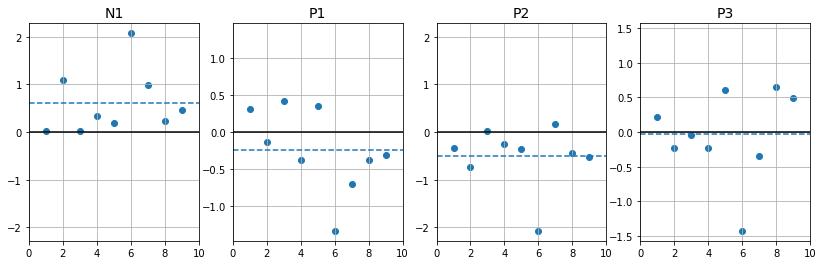

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

area        = 'A1'
event_count = 8
selected    = list(tgt_units)

for i, (m_name, m_vals) in enumerate(AEP_metrics_norm[area].items()):
    idxs_before_low, idxs_before_high = get_metric_averages(m_vals, event_count)
    
    zero_bin_stats = np.zeros((len(selected), 3))
    for j, unit_name in enumerate(selected):
        strain = spike_times[unit_name]

        bins, enter_low  = get_spike_counts(strain, tl[tgt_matrix[idxs_before_low][:, 0]][:, 0], hw=offset, bin_count=bin_count)
        bins, enter_high = get_spike_counts(strain, tl[tgt_matrix[idxs_before_high][:, 0]][:, 0], hw=offset, bin_count=bin_count)

        # get shuffled
        with h5py.File(h5_file, 'r') as f:
            shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])

        zero_bin_idx = len(bins[bins < 0]) - 1
        zero_bin_stats[j] = np.array([shuffled[zero_bin_idx][1], enter_low[zero_bin_idx], enter_high[zero_bin_idx]])

    deltas = (zero_bin_stats[:, 2] - zero_bin_stats[:, 1])/zero_bin_stats[:, 0]
    unit_count = len(deltas)
    d_max = np.abs(deltas).max()
    axes[i].scatter(np.arange(unit_count) + 1, deltas)
    axes[i].set_xlim(0, unit_count + 1)
    axes[i].set_ylim(-1.1*d_max, 1.1*d_max)
    axes[i].axhline(0, color='black')
    axes[i].grid()
    axes[i].set_title(m_name, fontsize=14)
    axes[i].axhline(deltas.mean(), ls='--')

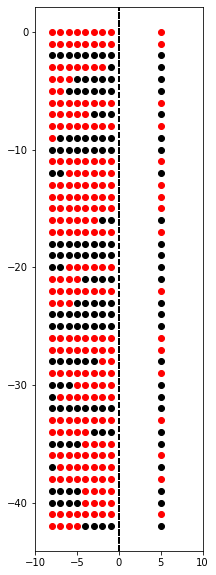

In [12]:
area = 'A1'
metric = 'P3'
event_count = 8

predictor_mean = AEP_metrics_norm[area][metric].mean()
idxs_before_low  = []
idxs_before_high = []

fig, ax = plt.subplots(1, 1, figsize=(3, 10))

for i, tgt_record in enumerate(tgt_matrix):
    ev_idx = tgt_record[2]
    m_before = AEP_metrics_norm[area][metric][ev_idx - event_count:ev_idx]
    idxs_low  = np.where(m_before < predictor_mean)[0]
    idxs_high = np.where(m_before > predictor_mean)[0]
    ax.scatter(idxs_high - event_count, -i * np.ones(len(idxs_high)), color='red')
    ax.scatter(idxs_low  - event_count, -i * np.ones(len(idxs_low)), color='black')
    ax.set_xlim(-10, 10)
    ax.axvline(0, color='black', ls='--')
    #is_high = m_before.mean() > predictor_mean
    is_high = (m_before > predictor_mean).all()
    ax.scatter(5, -i, color='red' if is_high else 'black')

### 2 - Unit state before entering

In [35]:
unit     = '4-2'
t_before = 2  # seconds
s_rate   = 100
i_rate   = single_units[unit]

idxs_before_low  = []
idxs_before_high = []
for i, tgt_record in enumerate(tgt_matrix):
    onset_tl_idx = tgt_record[0]
    m_before  = i_rate[onset_tl_idx - t_before*s_rate:onset_tl_idx]
    is_high = m_before.mean() > i_rate.mean()
    if is_high:
        idxs_before_high.append(i)
    else:
        idxs_before_low.append(i)
        
len(idxs_before_low), len(idxs_before_high)

(49, 22)

# Plot metrics before onset

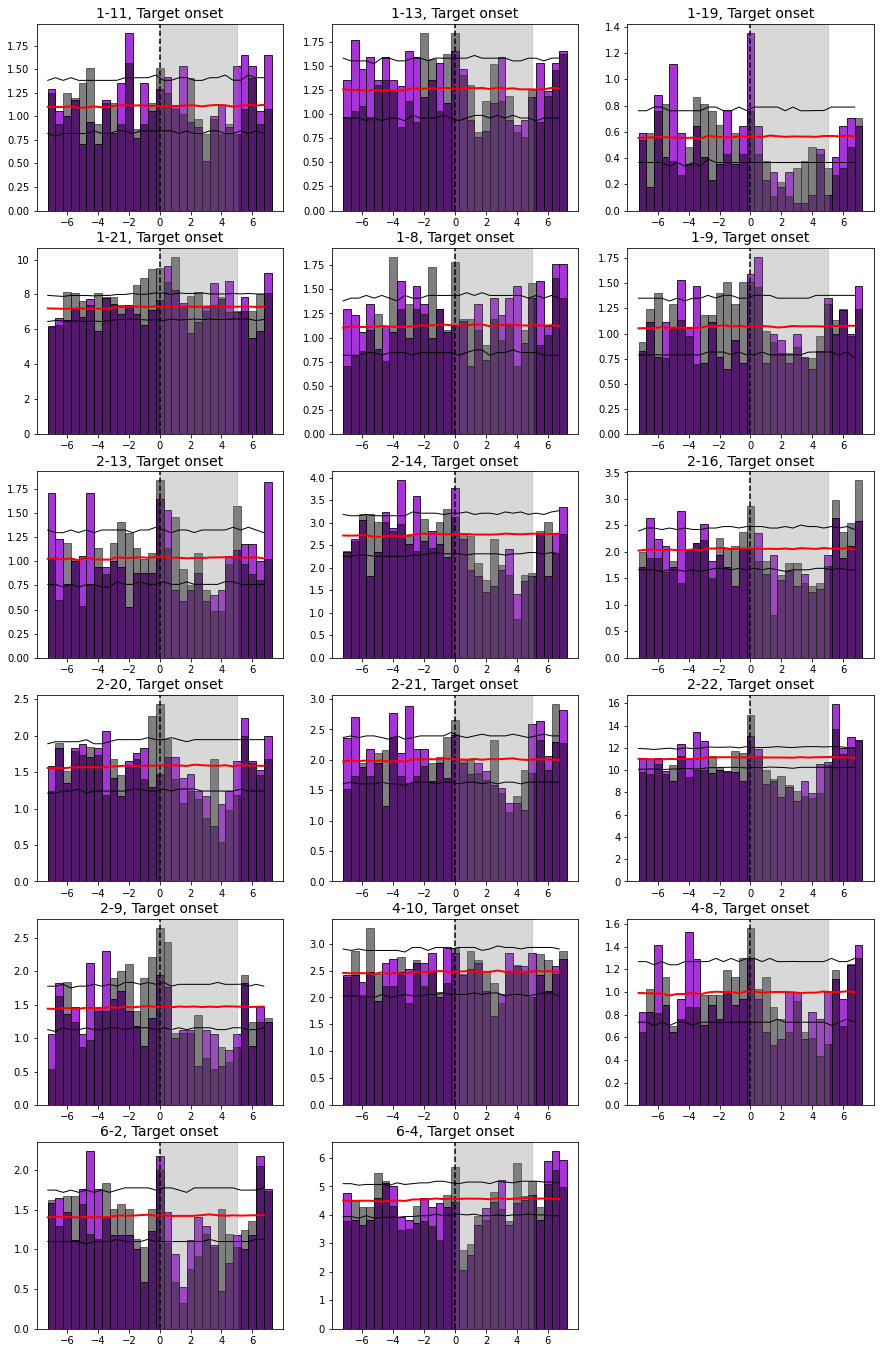

In [36]:
selected    = tgt_units
tgt_dur     = cfg['experiment']['target_duration']

event_times = tl[tgt_matrix[:, 0]][:, 0]
idxs_succ   = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss   = np.where(tgt_matrix[:, 4] == 0)[0]

metric_vals = AEP_metrics_norm['A1']['P1']
idxs_before_low, idxs_before_high = get_metric_averages(metric_vals, 8)

cols = 3
rows = int(np.ceil(len(selected)/cols))
fig = plt.figure(figsize=(15, rows*4))

zero_bin_stats = np.zeros((len(selected), 3))
for i, unit_name in enumerate(selected):
    strain = spike_times[unit_name]

    # compute original
    #bins, counts_enter = get_spike_counts(strain, tl[tgt_matrix[:, 0]][:, 0], hw=7, bin_count=bin_count)
    #bins, counts_enter = get_spike_counts(strain, tl[tgt_matrix[idxs_succ][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    bins, enter_low  = get_spike_counts(strain, tl[tgt_matrix[idxs_before_low][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    bins, enter_high = get_spike_counts(strain, tl[tgt_matrix[idxs_before_high][:, 0]][:, 0], hw=offset, bin_count=bin_count)
    
    # get shuffled
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
        
    zero_bin_idx = len(bins[bins < 0]) - 1
    zero_bin_stats[i] = np.array([shuffled[zero_bin_idx][1], enter_low[zero_bin_idx], enter_high[zero_bin_idx]])
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=enter_high, edgecolor='black', color='darkviolet', alpha=0.8, label='high')
    ax.hist(bins[:-1], bins=bins, weights=enter_low, edgecolor='black', color='black', alpha=0.5, label='high')
    ax.axvline(0, color='black', ls='--')
    ax.set_title("%s, Target onset" % unit_name, fontsize=14)
    ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 2], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')